In [22]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from urllib.request import urlopen 
import re
def read_url(url): 
    return re.sub('\\s+', ' ', urlopen(url).read().decode())

Estimating the number of enemy aircraft
-------------------------------------

In World War II, data analysts working for the Allies were tasked with estimating the number of German warplanes. The data included the serial numbers of the German planes that had been observed by Allied forces. These serial numbers gave the data analysts a way to come up with an answer.

To create an estimate of the total number of warplanes, the data analysts had to make some assumptions about the serial numbers. Here are two such assumptions, greatly simplified to make our calculations easier.

1. There are N planes, numbered $1, 2, ... , N$. 

2. The observed planes are drawn uniformly at random with replacement from the $N$ planes.

The goal is to estimate the number $N$.

Suppose you observe some planes and note down their serial numbers. How might you use the data to guess the value of $N$? A natural and straightforward method would be to simply use the **largest serial number observed**.

Let us see how well this method of estimation works. First, another simplification: Some historians now estimate that the German aircraft industry produced almost 100,000 warplanes of many different kinds, But here we will imagine just one kind. That makes Assumption 1 above easier to justify.

Suppose there are in fact $N = 300$ planes of this kind, and that you observe 30 of them. We can construct a table called ``serialno`` that contains the serial numbers 1 through $N$. We can then sample 30 times with replacement (see Assumption 2) to get our sample of serial numbers. Our estimate is the maximum of these 30 numbers.

In [23]:
N = 300
serialno = Table([np.arange(1, N+1)], ['serial number'])

In [24]:
serialno.sample(30, with_replacement=True).max()

serial number
282


As with all code involving random sampling, run it a few times to see the variation. You will observe that even with just 30 observations from among 300, the largest serial number is typically in the 250-300 range. 

In principle, the largest serial number could be as small as 1, if you were unlucky enough to see Plane Number 1 all 30 times. And it could be as large as 300 if you observe Plane Number 300 at least once. But usually, it seems to be in the very high 200's. It appears that if you use the largest observed serial number as your estimate of the total, you will not be very far wrong.

Let us generate some data to see if we can confirm this. We will use *iteration* to repeat the sampling procedure numerous times, each time noting the largest serial number observed. These would be our estimates of $N$ from all the numerous samples. We will then draw a histogram of all these estimates, and examine by how much they differ from $N = 300$.

In the code below, we will run 750 repetitions of the following process: Sample 30 times at random with replacement from 1 through 300 and note the largest number observed.

To do this, we will use a ``for`` loop. As you have seen before, we will start by setting up an empty table that will eventually hold all the estimates that are generated. As each estimate is the largest number in its sample, we will call this table ``maxes``.

For each integer (called ``i`` in the code) in the range 0 through 749 (750 total), the ``for`` loop executes the code in the body of the loop. In this example, it generates a random sample of 30 serial numbers, computes the maximum value, and augments the rows of ``maxes`` with that value.

In [25]:
sample_size = 30
repetitions = 750

maxes = Table([[]], ['maxes'])

for i in np.arange(repetitions):
    m = serialno.sample(sample_size, with_replacement=True).max()
    maxes.append([m.rows[0][0]])
    
maxes

maxes
299
296
295
267
296
289
290
291
300
291


Here is a histogram of the 750 estimates. First, notice that there is a bar to the right of 300. That is because intervals include the left end but not the right. The rightmost bar represents the samples for which the largest observed serial number was 300. 

As you can see, the estimates are all crowded up near 300, even though in theory they could be much smaller. The histogram indicates that as an estimate of the total number of planes, the largest serial number might be too low by about 10 to 25. But it is extremely unlikely to be underestimate the true number of planes by more than about 50.

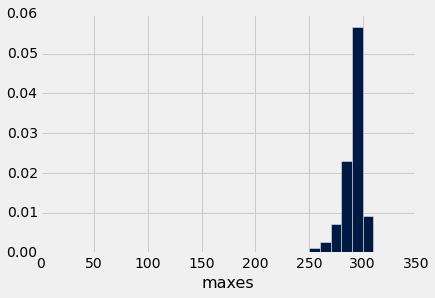

In [26]:
every_ten = np.arange(0, N+11, 10)
maxes.hist(bins=every_ten, normed=True)

The empirical distribution of a statistic
--------------------------------------

In the example above, the largest serial number is called a *statistic* (singular!). A *statistic* is any number computed using the data in a sample. 

The graph above is an empirical histogram. It displays the empirical or observed distribution of the statistic, based on 750 samples.

**The statistic could have been different.**

A fundamental consideration in using any statistic based on a random sample is that *the sample could have come out differently*, and therefore the statistic could have come out differently too. 

**Just how different could the statistic have been?**

The empirical distribution of the statistic gives an idea of how different the statistic could be, because it is based on recomputing the statistic for each one of many random samples.

However, there might still be more samples that could be generated. If you generate *all* possible samples, and compute the statistic for each of them, then you will have a complete enumeration of all the possible values of the statistic and all their probabilities. The resulting distribution is called the *probability distribution* of the statistic, and its histogram is called the *probability histogram*.

The probability distribution of a statistic is also called the *sampling distribution* of the statistic, because it is based on all possible samples.

The probability distribution of a statistic contains more accurate information about the statistic than an empirical distribution does. So it is good to compute the probability distribution exactly when feasible. This becomes easier with some expertise in probability theory. In the case of the largest serial number in a random sample, we can calculate the probability distribution by methods used earlier in this class.

The probability distribution of the largest serial number
------------------------------------------------------

For ease of comparison with the proportions in the empirical histogram above, we will calculate the probability that the statistic falls in each of the following bins: 0 to 250, 250 to 260, 260 to 270, 270 to 280, 280 to 290, and 290 to 300. To be consistent with the binning convention of ``hist``, we will work with intervals that include the left endpoint but not the right. Therefore we will also calculate the probability in the interval 300 to 310, noting that the only way the statistic can be in that interval is if it is exactly 300. 

Let us start with the left-most interval. What is the chance that the largest serial number is less than 250? That is the chance that all the serial numbers are less than 250:
$$
\left(\frac{249}{300}\right)^{30} ~ \approx ~ 0.00374
$$
We can express this quantity in terms of our population size `N` (300) and `sample_size` (30).

In [27]:
(249/N)**sample_size

0.003735448655171771

Similar reasoning gives us the chance that the largest serial number is in the interval 250 to 260, not including the right end. For this event to happen, the largest serial number must be less than 260 and *not* less than 250. In other words, all 30 serial numbers must be less than 290, and *not* all serial numbers must be less than 280. The chance of this is
$$
\left(\frac{259}{300}\right)^{30} - \left(\frac{249}{300}\right)^{30} ~ \approx ~ 0.0084
$$

In [28]:
(259/N)**sample_size - (249/N)**sample_size

0.008436364606449389

We can now gather these ideas into code that computes all of the probabilities. Like the leftmost interval, the rightmost interval gets its own calculation.

In [29]:
# Find the chance that in the leftmost interval:
probs = Table([[0], [(249/N)**sample_size]], ['Left', 'Chance'])

# Find the chances of the next four intervals:
edges = np.arange(250, 300, 10)
for edge in edges:
    excludes = edge - 1
    includes = edge + 9
    p = (includes/N)**sample_size - (excludes/N)**sample_size
    probs.append([edge, p])
    
# Find the chance of the rightmost interval (exactly 300):
probs.append([300, 1 - (299/N)**sample_size])
    
probs

Left,Chance
0,0.00373545
250,0.00843636
260,0.0257536
270,0.075442
280,0.212693
290,0.578626
300,0.0953137


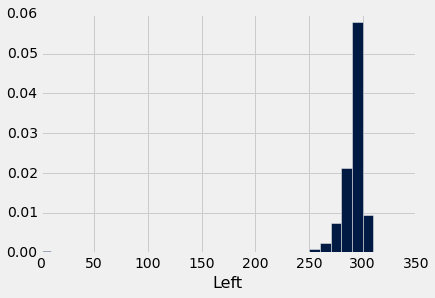

In [30]:
probs.hist(counts='Chance', bins=every_ten, normed=True)

This histogram displays the exact probability distribution of the largest serial number in a sample of 30. For comparison, here again is the empirical distribution of the statistic based on 750 repetitions of the sampling process.

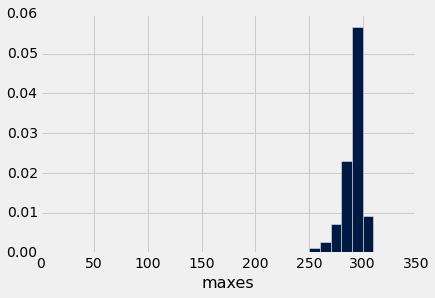

In [36]:
maxes.hist(bins=every_ten, normed=True)

The two histograms are extremely similar. Because of the large number of repetitions of the sampling process, the empirical distribution of the statistic looks very much like the probability distribution of the statistic.

When an empirical distribution of a statistic is based on a large number of samples, then it is likely to be a good approximation to the probability distribution of the statistic. This is of great practical importance, because the probability distribution of a statistic can sometimes be complicated to calculate exactly. 

Here is an example to illustrate this point. Thus far, we have used the largest observed serial number as an estimate of the total number of planes. But there are other possible estimates, and we will now consider one of them. 

The idea underlying this estimate is that the *average* of the observed serial numbers is likely be about halfway between 1 and $N$. Thus, if $A$ is the average, then
$$
A ~ \approx ~ \frac{1+N}{2} ~~~ \mbox{and so} ~~~ N \approx 2A - 1
$$

Thus a new statistic can be used to estimate the total number of planes: take the average of the observed serial numbers, double it, and subtract 1. 

How does this method of estimation compare with using the largest number observed? For the new statistic, it turns out that calculating the exact probability distribution takes some effort. However, with the computing power that we have, it is easy to generate an empirical distribution based on repeated sampling.

So let us construct an empirical distribution of our new estimate, based on 750 repetitions of the sampling process. The number of repetitions is chosen to be the same as it was for the earlier estimate. This will allow us to compare the two empirical distributions.

In [32]:
sample_size = 30
repetitions = 750

new_est = Table([[]], ['new estimates'])

for i in np.arange(repetitions):
    m = serialno.sample(sample_size, with_replacement=True).mean()
    new_est.append([2*(m.rows[0][0])-1])

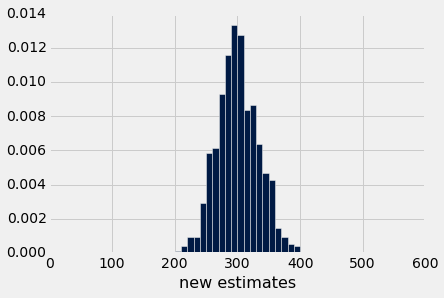

In [33]:
new_est.hist(bins=np.arange(0, 2*N+1, 10), normed=True)

Notice that unlike the earlier estimate, this one can overestimate the number of planes. This will happen when the average of the observed serial numbers is closer to $N$ than to 1.

**Comparison of the two methods**

To compare two histograms, we must use the same horizontal and vertical scales for both. Here are the empirical histograms of the new estimate and the old, both drawn to the same scale.

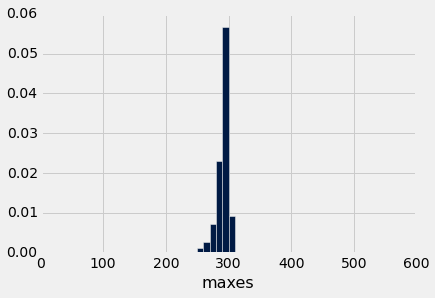

In [34]:
maxes.hist(bins=np.arange(0, 2*N+1, 10), normed=True)

(0, 0.06)

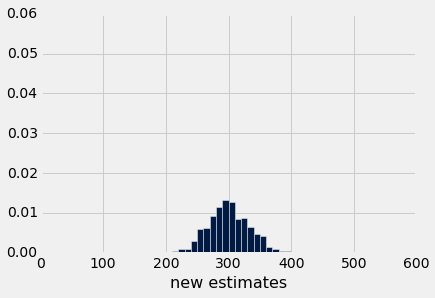

In [35]:
new_est.hist(bins=np.arange(0, 2*N+1, 10), normed=True)
plots.ylim((0,0.06))

You can see that the old method almost always underestimates; formally, we say that it is *biased*. But it has low variability, and is highly likely to be close to the true total number of planes. 

The new method overestimates about as often as it underestimates, and thus is called *unbiased* on average in the long run. However, it is more variable than the old estimate, and thus is prone to larger absolute errors.

This is an instance of a *bias-variance tradeoff* that is not uncommon among competing estimates. Which estimate you decide to use will depend on the kinds of errors that matter the most to you. In the case of enemy warplanes, underestimating the total number might have grim consequences, in which case you might choose to use the more variable method that overestimates about half the time. On the other hand, if overestimation leads to needlessly high costs of guarding against planes that don't exist, you might be satisfied with the method that underestimates by a modest amount. 